# Importation des packages

In [1]:
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

# Préparation des données 

In [2]:
IMAGE_SIZE=128
BATCH_SIZE = 128
FOLDER = "Donnee_DP_réduite"
# create generator
datagen = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

# prepare an iterators for each dataset
train = datagen.flow_from_directory(os.path.join(FOLDER,'train'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse", color_mode="rgb", batch_size=BATCH_SIZE)
val = datagen_val.flow_from_directory(os.path.join(FOLDER,'val'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)
# confirm the iterator works
batchX, batchy = train.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 2291 images belonging to 2 classes.
Found 285 images belonging to 2 classes.
Batch shape=(128, 128, 128, 3), min=0.000, max=1.000


### NOMBRE DE CLASSE 

In [4]:
NUM_CLASSES=2

# Construction du réseau MobileNet V2
Possibilitée de changer les hyperparamètres dans la compilation du modèle

In [6]:
from tensorflow.keras.applications import MobileNetV2

In [7]:
def build_MobileNetV2():
    model = MobileNetV2(include_top=True, weights=None, classes=NUM_CLASSES)
    return model

In [8]:
model = build_MobileNetV2()

METRICS = ["accuracy"]
    
model.compile(
        optimizer='adam',
        loss= tf.losses.SparseCategoricalCrossentropy(),
        metrics=METRICS
)

In [9]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

# Learning Rate Schedules et sauvegarde du modéle

Les learning rate schedules visent à ajuster le taux d'apprentissage pendant la formation en réduisant le taux d'apprentissage selon un schedule prédéfini.

In [10]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(FOLDER+"_model_sans_DA_Conta_MobileNetV2.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

# Entrainement du modèle

In [11]:
history = model.fit(
    train,
    validation_data=val,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=100
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 3 steps
Epoch 1/100
18/18 [==============================] - 31s 2s/step - loss: 1.8827 - accuracy: 0.5072 - val_loss: 14.8010 - val_accuracy: 0.5579
Epoch 2/100
18/18 [==============================] - 21s 1s/step - loss: 0.7513 - accuracy: 0.5858 - val_loss: 4.9027 - val_accuracy: 0.5579
Epoch 3/100
18/18 [==============================] - 19s 1s/step - loss: 0.7106 - accuracy: 0.5919 - val_loss: 2.4652 - val_accuracy: 0.4421
Epoch 4/100
18/18 [==============================] - 20s 1s/step - loss: 0.6885 - accuracy: 0.5893 - val_loss: 0.6888 - val_accuracy: 0.5579
Epoch 5/100
18/18 [==============================] - 19s 1s/step - loss: 0.6489 - accuracy: 0.6351 - val_loss: 0.6853 - val_accuracy: 0.5579
Epoch 6/100
18/18 [==============================] - 20s 1s/step - loss: 0.5936 - accuracy: 0.6805 - val_loss: 0.6847 - val_accuracy: 0.5579
Epoch 7/100
18/18 [==============================] - 19s 1s/st

# Affichage des résultats pour images d'entrainement et de validation

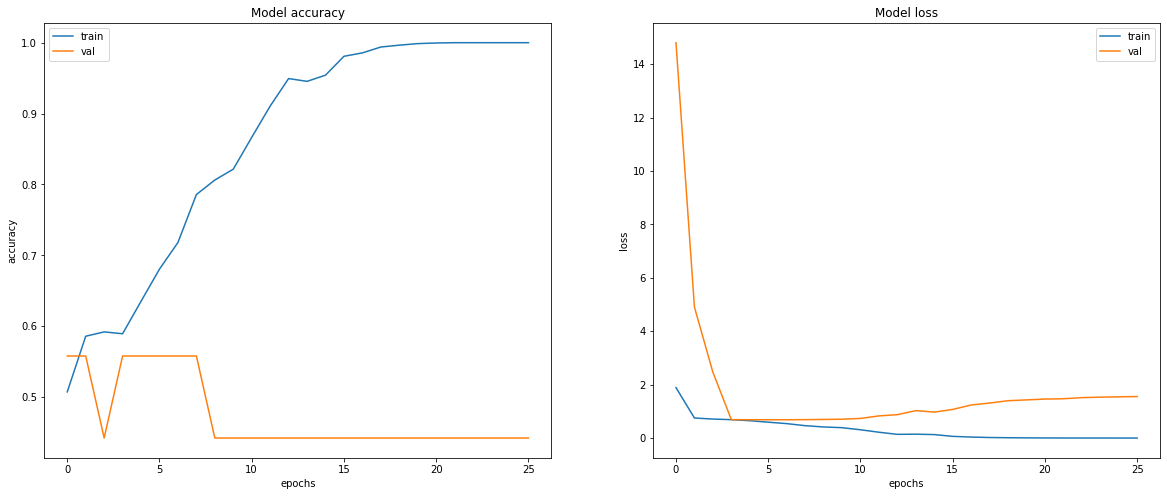

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Préparation des images de test

In [13]:
datagen_test = ImageDataGenerator(rescale=1./255)

test = datagen.flow_from_directory(os.path.join(FOLDER,'test'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)

Found 287 images belonging to 2 classes.


# Chargement du modèle construit 

In [14]:
model_sans_DA = tf.keras.models.load_model("Donnee_DP_model_sans_DA_Conta_MobileNetV2.h5")

# Evaluation du modèle à l'aide des données test

In [15]:
_ = model_sans_DA.evaluate(test)

  ...
    to  
  ['...']
3/3 [==============================] - 3s 1s/step - loss: 1.0056 - accuracy: 0.5575
